

```
Ý tưởng cơ bản là Boosting sẽ tạo ra một loạt các model yếu, học bổ sung lẫn nhau. Nói cách khác, trong Boosting, các model sau sẽ cố gắng học để hạn chế lỗi lầm của các model trước.

Vậy làm thể nào để hạn chế được sai lầm từ các model trước ? Boosting tiến hành đánh trọng số cho các mô hình mới được thêm vào dựa trên các cách tối ưu khác nhau. Tùy theo cách đánh trọng số (cách để các model được fit một cách tuần tự) và cách tổng hợp lại các model, từ đó hình thành nên 2 loại Boosting :

Adaptive Boosting (AdaBoost)
Gradient Boosting
Chúng ta sẽ phân tích sâu hơn về 2 dạng Boosting này ở phần sau. Để kết thúc phần này, có một vài nhận xét về Boosting như sau:

Boosting là một quá trình tuần tự, không thể xử lí song song, do đó, thời gian train mô hình có thể tương đối lâu.
Sau mỗi vòng lặp, Boosting có khả năng làm giảm error theo cấp số nhân.
Boosting sẽ hoạt động tốt nếu base learner của nó không quá phức tạp cũng như error không thay đổi quá nhanh.
Boosting giúp làm giảm giá trị bias cho các model base learner.

https://viblo.asia/p/gradient-boosting-tat-tan-tat-ve-thuat-toan-manh-me-nhat-trong-machine-learning-YWOZrN7vZQ0

https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction/comments#1104857

https://github.com/NGYB/Stocks/blob/master/StockPricePrediction/StockPricePrediction_v1c_xgboost.ipynb

```



In [203]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
# stk_path = "TSLA.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

In [204]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [205]:
df = pd.read_csv("../db/Microsoft.csv", sep = ",")
# df

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()


,date,high,low,open,close,volume,adj_close,name,month
0,2016-06-13,24.780001,24.275000,24.672501,24.334999,152082000.0,22.733387,AAPL,6
1,2016-06-14,24.620001,24.187500,24.330000,24.365000,127727600.0,22.761415,AAPL,6
2,2016-06-15,24.602501,24.257500,24.455000,24.285000,117780800.0,22.686680,AAPL,6
3,2016-06-16,24.437500,24.017500,24.112499,24.387501,125307200.0,22.782436,AAPL,6
4,2016-06-17,24.162500,23.825001,24.155001,23.832500,244032800.0,22.263964,AAPL,6


Text(0, 0.5, 'USD')

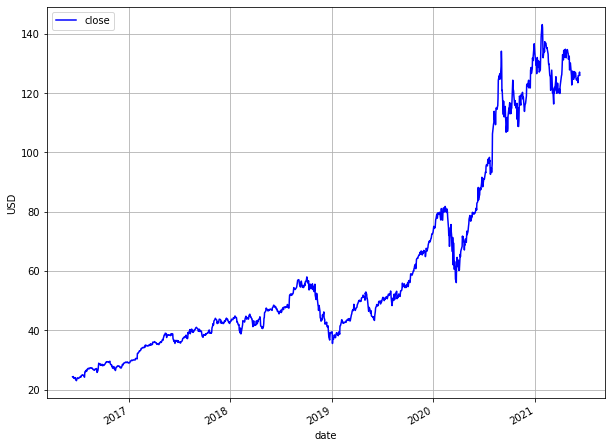

In [206]:
# Plot  close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")



```

Feature Engineering
We will generate the following features:

Mean 'adj_close' of each month
Difference between high and low of each day
Difference between open and close of each day
Mean volume of each month
```



In [207]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,volume,adj_close,name,month,range_hl,range_oc
0,2016-06-13,152082000.0,22.733387,AAPL,6,0.505001,0.337502
1,2016-06-14,127727600.0,22.761415,AAPL,6,0.432501,-0.035000
2,2016-06-15,117780800.0,22.686680,AAPL,6,0.345001,0.170000
3,2016-06-16,125307200.0,22.782436,AAPL,6,0.420000,-0.275002
4,2016-06-17,244032800.0,22.263964,AAPL,6,0.337500,0.322500




```

Now we use lags up to N number of days to use as features.
```



In [208]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [209]:
# !jupyter nbextension enable --py widgetsnbextension

In [210]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

100%|██████████| 3/3 [00:00<00:00, 172.73it/s]


,date,volume,adj_close,name,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2016-06-16,125307200.0,22.782436,AAPL,6,0.4200,-0.275002,3,22.686680,0.345001,0.170000,117780800.0,22.761415,0.432501,-0.035000,127727600.0,22.733387,0.505001,0.337502,152082000.0
4,2016-06-17,244032800.0,22.263964,AAPL,6,0.3375,0.322500,4,22.782436,0.420000,-0.275002,125307200.0,22.686680,0.345001,0.170000,117780800.0,22.761415,0.432501,-0.035000,127727600.0
5,2016-06-20,137647600.0,22.210251,AAPL,6,0.3850,0.225000,5,22.263964,0.337500,0.322500,244032800.0,22.782436,0.420000,-0.275002,125307200.0,22.686680,0.345001,0.170000,117780800.0
6,2016-06-21,142185600.0,22.399418,AAPL,6,0.4175,-0.242500,6,22.210251,0.385000,0.225000,137647600.0,22.263964,0.337500,0.322500,244032800.0,22.782436,0.420000,-0.275002,125307200.0
7,2016-06-22,116876400.0,22.315344,AAPL,6,0.3850,0.174999,7,22.399418,0.417500,-0.242500,142185600.0,22.210251,0.385000,0.225000,137647600.0,22.263964,0.337500,0.322500,244032800.0


In [211]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1255 entries, 3 to 1257
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1255 non-null   datetime64[ns]
 1   volume           1255 non-null   float64       
 2   adj_close        1255 non-null   float64       
 3   name             1255 non-null   object        
 4   month            1255 non-null   int64         
 5   range_hl         1255 non-null   float64       
 6   range_oc         1255 non-null   float64       
 7   order_day        1255 non-null   int64         
 8   adj_close_lag_1  1255 non-null   float64       
 9   range_hl_lag_1   1255 non-null   float64       
 10  range_oc_lag_1   1255 non-null   float64       
 11  volume_lag_1     1255 non-null   float64       
 12  adj_close_lag_2  1255 non-null   float64       
 13  range_hl_lag_2   1255 non-null   float64       
 14  range_oc_lag_2   1255 non-null   float64

In [212]:
# Get mean and std dev at timestamp t using values from t-1, ..., t-N
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,volume,adj_close,name,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2016-06-16,125307200.0,22.782436,AAPL,6,0.4200,-0.275002,3,22.686680,0.345001,...,0.337502,152082000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-06-17,244032800.0,22.263964,AAPL,6,0.3375,0.322500,4,22.782436,0.420000,...,-0.035000,127727600.0,22.782436,NaN,0.420000,NaN,-0.275002,NaN,1.253072e+08,NaN
5,2016-06-20,137647600.0,22.210251,AAPL,6,0.3850,0.225000,5,22.263964,0.337500,...,0.170000,117780800.0,22.523200,0.366616,0.378750,0.058337,0.023749,0.422498,1.846700e+08,8.395168e+07
6,2016-06-21,142185600.0,22.399418,AAPL,6,0.4175,-0.242500,6,22.210251,0.385000,...,-0.275002,125307200.0,22.418884,0.315989,0.380833,0.041408,0.090833,0.320551,1.689959e+08,6.527616e+07
7,2016-06-22,116876400.0,22.315344,AAPL,6,0.3850,0.174999,7,22.399418,0.417500,...,0.322500,244032800.0,22.291211,0.097483,0.380000,0.040234,0.101667,0.302018,1.746220e+08,6.015432e+07


In [213]:

# Split into train, dev and test set
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 753
num_cv = 251
num_test = 251
train.shape = (753, 28)
cv.shape = (251, 28)
train_cv.shape = (1004, 28)
test.shape = (251, 28)


In [214]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 3.84965425e+01  3.84633986e+01  6.75159371e-01 -2.60723742e-02
  1.25156586e+08  3.84303410e+01  6.74877167e-01 -2.60391717e-02
  1.25229249e+08  3.83970440e+01  6.74751008e-01 -2.56075637e-02
  1.25288147e+08]
scaler.var_ = [7.19477072e+01 7.21674257e+01 1.96937328e-01 2.18931384e-01
 2.94251511e+15 7.23815891e+01 1.97014238e-01 2.18929960e-01
 2.93890776e+15 7.25909605e+01 1.97045100e-01 2.19103315e-01
 2.93945529e+15]
train_scaled.shape = (753, 13)
train_scaled.shape = (753, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.852598,-1.857146,-0.743974,0.419047,-0.135972,-1.841727,-0.546061,-0.019151,0.046085,-1.838450,-0.382408,0.775734,0.494199,2016-06-16,6
1,-1.913723,-1.845874,-0.574973,-0.532012,0.002777,-1.850511,-0.743193,0.418977,-0.137396,-1.835161,-0.545734,-0.020065,0.044994,2016-06-17,6
2,-1.920055,-1.906906,-0.760878,0.744971,2.191470,-1.839256,-0.574225,-0.532085,0.001438,-1.843932,-0.742851,0.417889,-0.138469,2016-06-20,6
3,-1.897754,-1.913229,-0.653841,0.536594,0.230271,-1.900197,-0.760094,0.744902,2.191475,-1.832693,-0.573896,-0.532797,0.000351,2016-06-21,6
4,-1.907665,-1.890961,-0.580608,-0.462551,0.313928,-1.906511,-0.653078,0.536524,0.229071,-1.893547,-0.759750,0.743685,2.190184,2016-06-22,6


In [153]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [1.57594366e+02 1.57433107e+02 5.39440688e+00 2.37440979e-02
 4.53092584e+06 1.57271901e+02 5.39175022e+00 2.89745407e-02
 4.53718907e+06 1.57112895e+02 5.38598119e+00 1.91506069e-02
 4.54334169e+06]
scaler_train_cv.var_ = [1.22037114e+04 1.21972155e+04 1.94019046e+01 1.78782284e+01
 1.74818553e+13 1.21900829e+04 1.93791003e+01 1.78456286e+01
 1.75646038e+13 1.21836534e+04 1.92909363e+01 1.77558193e+01
 1.76665611e+13]
train_cv_scaled.shape = (1931, 13)
train_cv_scaled.shape = (1931, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.252773,-1.226656,0.058027,0.713356,0.882028,-1.208618,0.392591,0.457112,3.018341,-1.206952,0.472211,-1.165027,3.383872,2010-07-02,7
1,-1.280744,-1.251647,-0.228027,0.893098,0.145624,-1.225555,0.058664,0.712769,0.878453,-1.207496,0.394800,0.460598,3.008155,2010-07-06,7
2,-1.283551,-1.279625,-0.277974,0.914383,0.558694,-1.250553,-0.227558,0.892675,0.143786,-1.224437,0.060112,0.716900,0.874451,2010-07-07,7
3,-1.268524,-1.282432,-0.850082,0.136287,0.571801,-1.278540,-0.277534,0.913980,0.555882,-1.249442,-0.226764,0.897261,0.141907,2010-07-08,7
4,-1.269067,-1.267402,-0.781974,-0.317800,0.760673,-1.281347,-0.849979,0.135173,0.568958,-1.277436,-0.276854,0.918620,0.552812,2010-07-09,7


In [215]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
756,2019-06-14,-0.630549,-0.522464,1.153013,1.127088,-0.346164,-0.780924,1.076006,-0.900851,-0.175155,-0.140046,-0.922595,1.062641
757,2019-06-17,-1.154362,0.552965,0.601397,0.702553,0.442332,-1.144885,-1.029200,0.967988,0.061212,-0.434192,1.143707,-0.709515
758,2019-06-18,0.395348,-1.137235,0.741887,-1.133889,0.755945,0.377944,-0.469130,-0.679184,1.148314,-1.051160,0.111700,0.939460
759,2019-06-19,1.133579,-0.376397,-0.757182,1.129537,-0.772399,-0.357138,-1.144738,0.703445,0.441293,1.086328,-0.882160,-0.204168
760,2019-06-20,0.456564,0.690229,-1.146793,-0.654677,1.151079,-0.496402,1.090422,-0.874202,-0.216220,0.057624,0.969942,-1.027566


In [216]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1007,2020-06-12,-0.984714,1.014615,-0.029901,0.833134,-1.108966,0.275832,1.113527,-0.292107,-0.821420,1.083392,-0.195725,-0.887667
1008,2020-06-15,-0.409867,-0.729950,1.139817,0.272291,0.835653,-1.107944,0.121753,0.933549,-1.055302,0.538615,0.615238,-1.153853
1009,2020-06-16,1.054848,-0.120641,-0.934207,-0.750114,-0.385204,1.135318,-1.095137,0.230541,0.864596,-1.154442,0.556077,0.598365
1010,2020-06-17,1.098347,-0.240587,-0.857760,-1.150500,0.490031,0.660469,0.109340,-1.050177,0.940837,-0.087753,-0.953232,1.040985
1011,2020-06-18,0.528765,0.624609,-1.153374,-0.982507,-0.034113,1.016620,0.856713,0.242115,-1.098828,-0.985202,1.014169,-0.028966


In [217]:
# Split into X and y
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (753, 12)
y_train.shape = (753,)
X_cv.shape = (251, 12)
y_cv.shape = (251,)
X_train_cv.shape = (1004, 12)
y_train_cv.shape = (1004,)
X_sample.shape = (251, 12)
y_sample.shape = (251,)


In [218]:

# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (753, 12)
y_train_scaled.shape = (753,)
X_cv_scaled.shape = (251, 12)
X_train_cv_scaled.shape = (1931, 12)
y_train_cv_scaled.shape = (1931,)
X_sample_scaled.shape = (251, 12)


Text(0.5, 1.0, 'Without scaling')

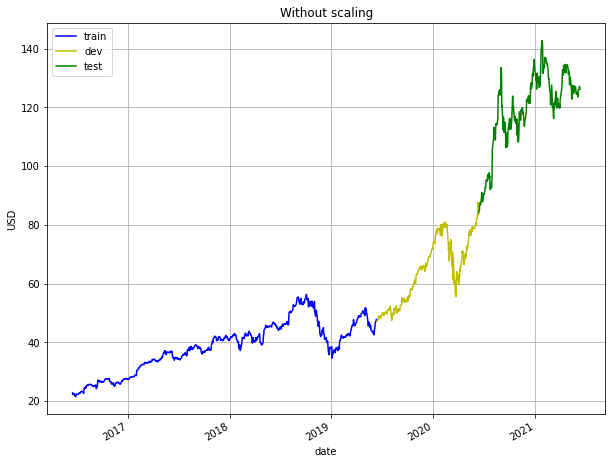

In [219]:
# EDA
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

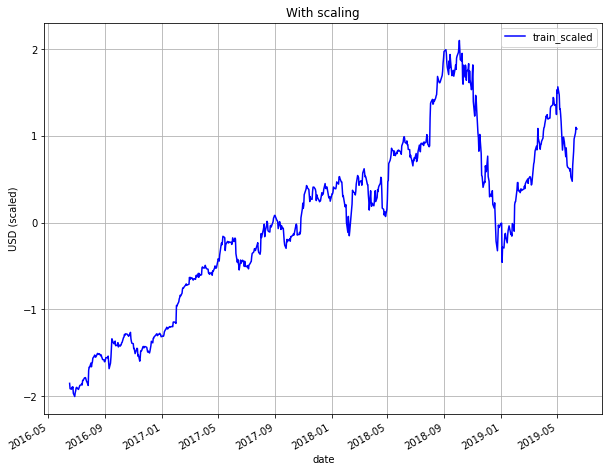

In [220]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [221]:
# Train the model using XGBoost
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [222]:
# Predict on train set
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.390
MAPE on train set = 0.703%


Text(0.5, 1.0, 'Without scaling')

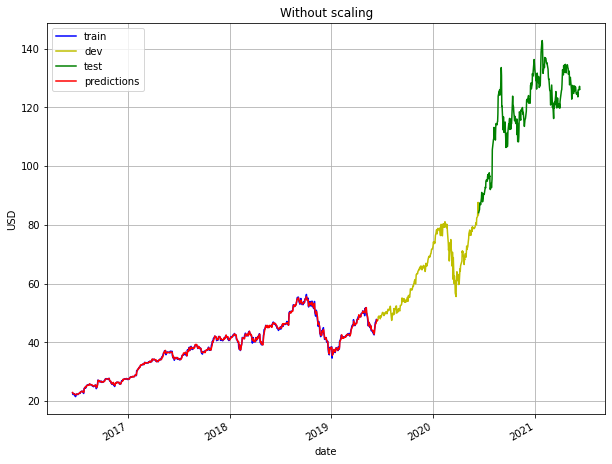

In [223]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [224]:
# Predict on dev set
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 1.630
MAPE on dev set = 1.615%


/Users/anhnguyenhoang/miniconda/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Text(0, 0.5, 'USD')

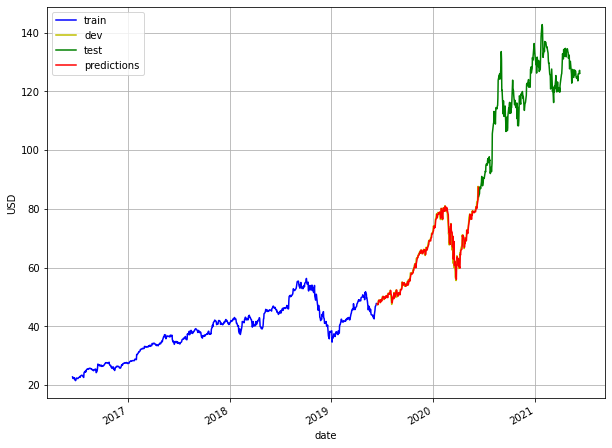

In [225]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

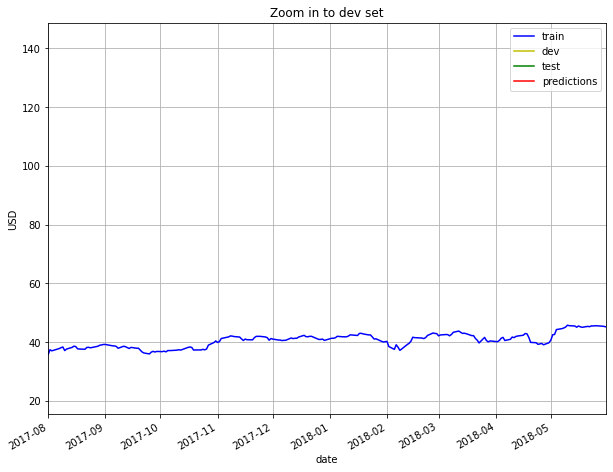

In [226]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

In [227]:

# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('volume_lag_2', 0.00083323766),
 ('range_oc_lag_2', 0.0008895224),
 ('range_hl_lag_3', 0.0009739855),
 ('range_oc_lag_3', 0.0010430596),
 ('volume_lag_3', 0.0010735423),
 ('range_oc_lag_1', 0.0011279639),
 ('range_hl_lag_2', 0.0011323455),
 ('adj_close_lag_2', 0.10056418),
 ('adj_close_lag_3', 0.18165499),
 ('adj_close_lag_1', 0.7091406)]

In [228]:
# Tuning N (no. of days to use as features)
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


In [229]:
# Use N = 3 for lowest RMSE and MAPE


In [230]:
# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 30/30 [01:15<00:00,  2.52s/it]

Minutes taken = 1.2577316045761109


,n_estimators,max_depth,rmse,mape_pct
0,10,2,1.614073,1.612105
1,10,3,1.617491,1.607716
2,10,4,1.621436,1.612457
3,10,5,1.618566,1.610015
4,10,6,1.621119,1.613670
...,...,...,...,...
235,300,5,1.628198,1.621294
236,300,6,1.630585,1.619338
237,300,7,1.634474,1.623274
238,300,8,1.628980,1.616567


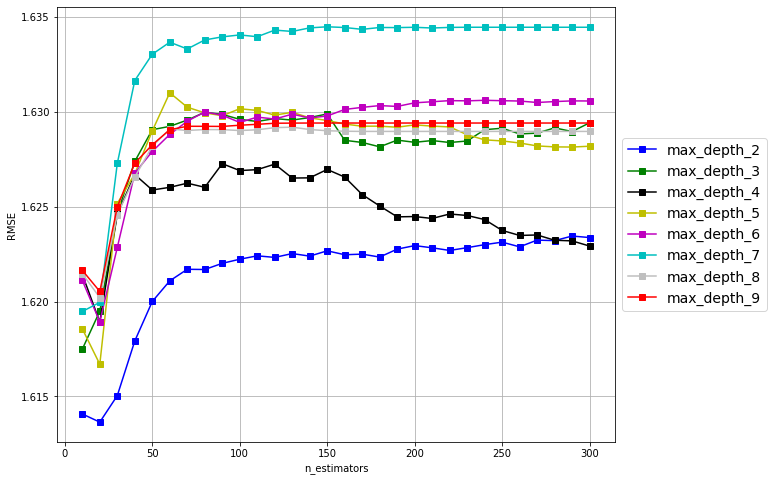

In [231]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [232]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.614
optimum params = 


(20, 2)

In [233]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.596%
optimum params = 


(20, 4)

In [234]:
# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

Minutes taken = 0.03754996458689372


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,1.791038,1.787501
1,0.001,6,1.791038,1.787501
2,0.001,7,1.791038,1.787501
3,0.001,8,1.791038,1.787501
4,0.001,9,1.791038,1.787501
...,...,...,...,...
107,0.300,16,1.644577,1.628681
108,0.300,17,1.644572,1.628680
109,0.300,18,1.644572,1.628680
110,0.300,19,1.641238,1.630289


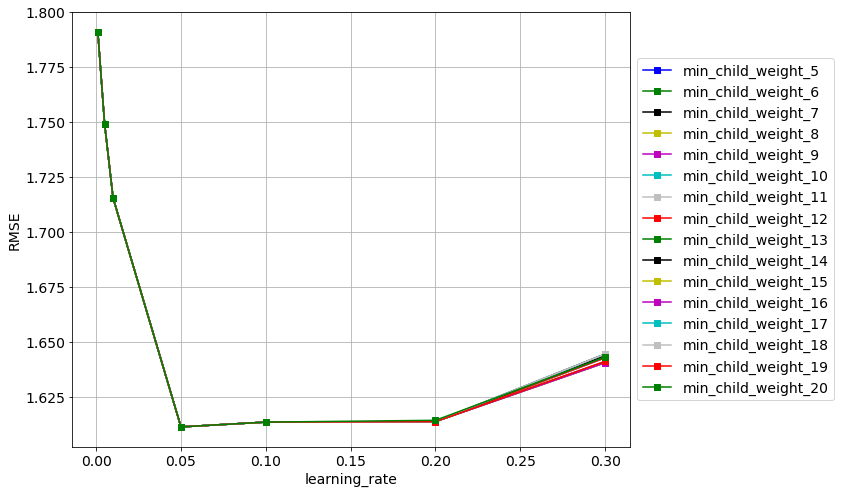

In [235]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [236]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.611
optimum params = 


(0.05, 5)

In [237]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.598%
optimum params = 


(0.2, 5)

In [238]:
# Tuning XGBoost - subsample(default=1) and gamma(default=0)
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 10/10 [00:01<00:00,  5.56it/s]

Minutes taken = 0.030040733019510903


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,1.614525,1.618864
1,0.1,0.2,1.614525,1.618864
2,0.1,0.3,1.614525,1.618864
3,0.1,0.4,1.614525,1.618864
4,0.1,0.5,1.614525,1.618864
...,...,...,...,...
95,1.0,0.6,1.611469,1.613305
96,1.0,0.7,1.611469,1.613305
97,1.0,0.8,1.611469,1.613305
98,1.0,0.9,1.611469,1.613305


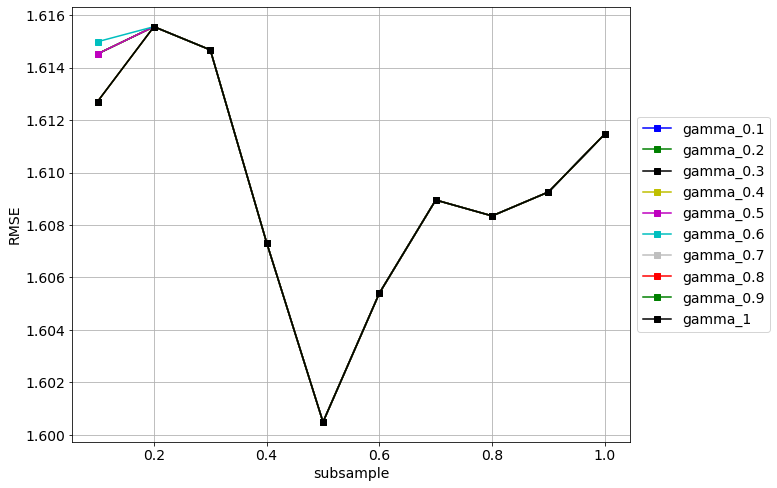

In [239]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [240]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.600
optimum params = 


(0.5, 0.1)

In [241]:

# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.610%
optimum params = 


(0.8, 0.1)

In [242]:
# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

Minutes taken = 0.016664214928944907


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1.789975,1.874332
1,0.5,0.6,1.789975,1.874332
2,0.5,0.7,1.822290,1.925200
3,0.5,0.8,1.822290,1.925200
4,0.5,0.9,1.771620,1.854219
5,0.5,1.0,1.723408,1.803040
6,0.6,0.5,1.725029,1.773913
7,0.6,0.6,1.700716,1.756359
8,0.6,0.7,1.700716,1.756359
9,0.6,0.8,1.697402,1.762493


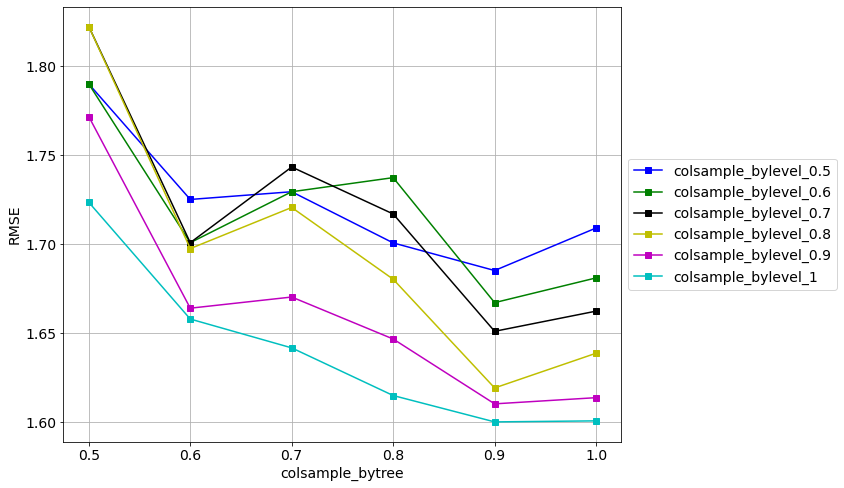

In [243]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [244]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.600
optimum params = 


(0.9, 1.0)

In [245]:

# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.613%
optimum params = 


(1.0, 1.0)

In [246]:
# Tuned params
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,20.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.050
3,min_child_weight,1.000,5.000
4,subsample,1.000,0.500
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.100
8,rmse,1.630,1.600
9,mape_pct,1.615,1.613


In [247]:
# Final model
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2.769
MAPE on test set = 1.696%


Text(0, 0.5, 'USD')

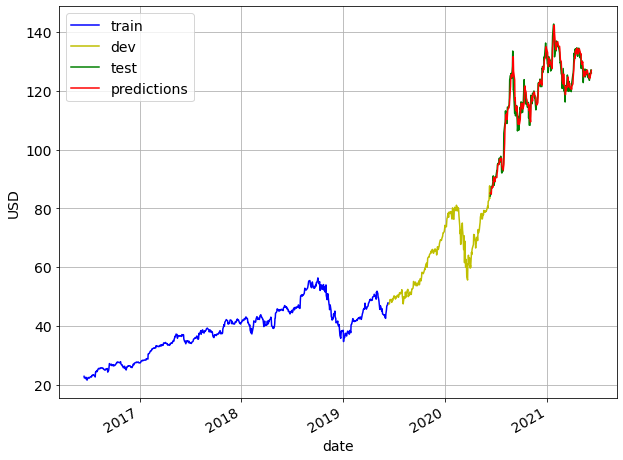

In [248]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [249]:
# # Plot adjusted close over time, for test set only
# rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
# ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
# ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
# ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
# ax.legend(['train', 'dev', 'test', 'predictions'])
# ax.set_xlabel("date")
# ax.set_ylabel("USD")
# # ax.set_xlim([date(2018, 4, 1), date(2020, 2, 28)])
# # ax.set_ylim([130, 155])
# ax.set_title("Zoom in to test set")

Text(0, 0.5, 'USD')

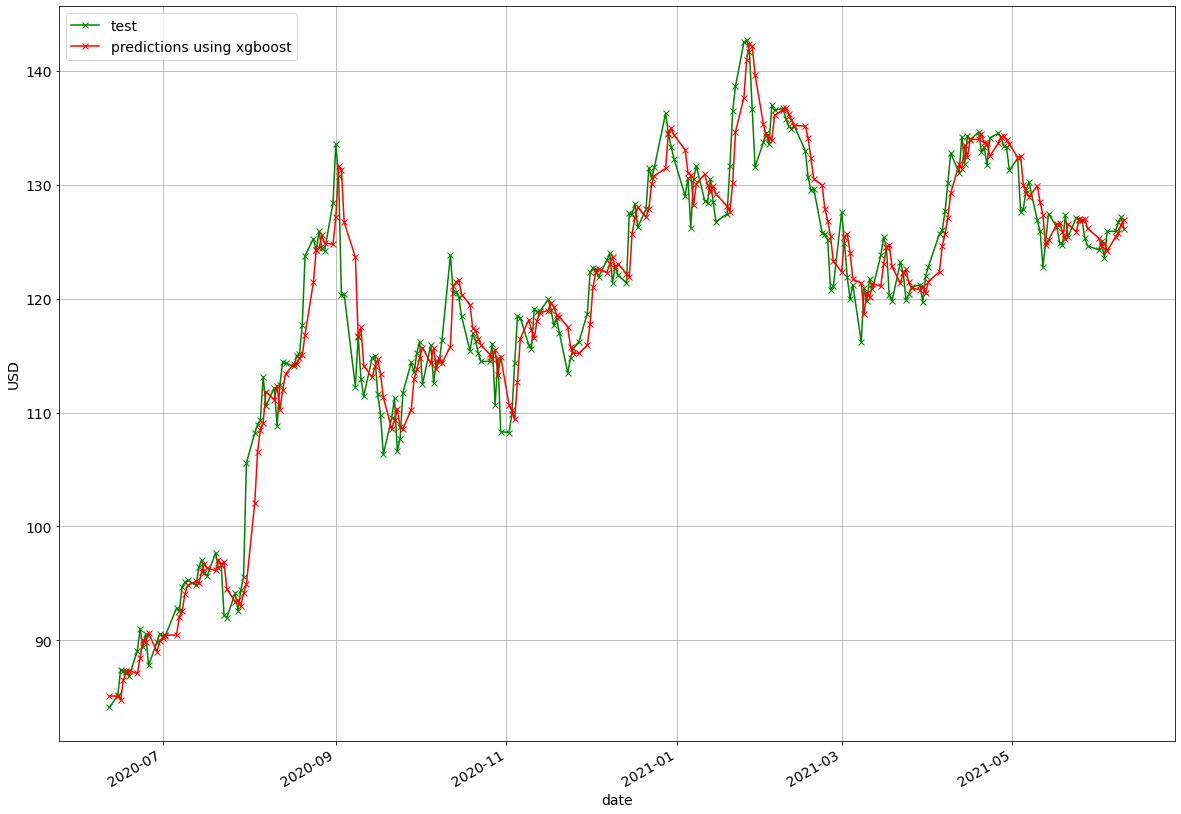

In [250]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 20, 15 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
# ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
# ax.set_ylim([130, 155])

In [251]:
# Save as csv
test_xgboost = est_df
test_xgboost.columns = [ 'Prediction','Close','Date']
test_xgboost.index=pd.to_datetime(test_xgboost['Date'])
test_xgboost=test_xgboost.drop(["Date"],axis=1)

test_xgboost.to_csv("../out/MSFT_XGboost_1.csv")
# test_xgboost



```
Findings
By scaling the features properly, we can get good results for our predictions
RMSE and MAPE changed very little with hyperparameter tuning
The final RMSE and MAPE for test set are 1.162 and 0.58% respectively
```

